<a href="https://colab.research.google.com/github/jeremyrupprecht/Stack-Overflow-Data-Analysis-Term-Project-SENG-550/blob/main/Copy_of_SENG550Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Collab Spark Setup

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

--2023-02-10 06:22:44--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.1-bin-hadoop3.tgz’

spark-3.3.1-bin-had 100%[===================>] 285.48M   152MB/s    in 1.9s    

2023-02-10 06:22:46 (152 MB/s) - ‘spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]



In [ ]:
!tar -xvf spark-3.3.1-bin-hadoop3.tgz

spark-3.3.1-bin-hadoop3/
spark-3.3.1-bin-hadoop3/LICENSE
spark-3.3.1-bin-hadoop3/NOTICE
spark-3.3.1-bin-hadoop3/R/
spark-3.3.1-bin-hadoop3/R/lib/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.1-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.1-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.1-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.1-bin-hadoop3/R/lib/Spar

In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# **Exploratory Data Analysis**

We start our project off by analysing and massaging the data to suit our needs. For the purposes of this project we need to work our data into a machine-readable format and remove outliers to make it more effective.

**Downloads .csv file to cluster**

In [ ]:
!rm answers.csv
!wget https://www.ics.uci.edu/~duboisc/stackoverflow/answers.csv

rm: cannot remove 'answers.csv': No such file or directory
--2023-02-10 06:23:06--  https://www.ics.uci.edu/~duboisc/stackoverflow/answers.csv
Resolving www.ics.uci.edu (www.ics.uci.edu)... 128.195.1.88
Connecting to www.ics.uci.edu (www.ics.uci.edu)|128.195.1.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25117987 (24M) [text/csv]
Saving to: ‘answers.csv’

answers.csv         100%[===================>]  23.95M  25.2MB/s    in 1.0s    

2023-02-10 06:23:07 (25.2 MB/s) - ‘answers.csv’ saved [25117987/25117987]



**First we get text from .csv into RDD**

In [ ]:
import os.path
sc = spark.sparkContext

filepath = 'answers.csv'
baseDir = os.path.join('.')
inputPath = os.path.join(filepath)
fileName = os.path.join(baseDir, inputPath)

stackRDD = sc.textFile(fileName, 8) #8 partitions
print(stackRDD.count())

263541


**Then we extract the desired fields out of each line**

Fields are extracted into Key-Value pairs of the form: (unique question id, (question score, question views, tags, answer time in seconds))

In [ ]:

#(question id, (question score, question views, [tags], answer time <in seconds>))
#Extracts desired fields from line
def extractFields(line):
  sep = line.split('"')    #sep[1] is qid, sep[3] is tags, sep[2] and sep[4] are fields
  tags = sep[3].split(',') #gets list of tags
  feats = sep[2].split(',') + sep[4].split(',') #splits line into rest of fields
  answerTime = int(feats[12]) - int(feats[4]) #finds time to answer, in seconds

  # extracted fields are returned as KV pairs
  return (feats[1], (int(feats[3]), int(feats[7]), tags, answerTime))

#removes header from RDD
def removeHeader(line):
  fields = line.split(',')
  if fields[0] == '""':
    return False
  else:
    return True

stackPairRDD = stackRDD.filter(removeHeader).map(extractFields) #removes header and extracts field
groupedPairRDD = stackPairRDD.groupByKey().mapValues(list)
numAnswers = groupedPairRDD.count()
print(numAnswers)
print(groupedPairRDD.take(10))

83423
[('563366', [(0, 179, ['core-animation'], 2923)]), ('563367', [(0, 247, ['django', 'django-models'], 55714), (0, 247, ['django', 'django-models'], 56458)]), ('563395', [(2, 135, ['css'], 164), (2, 135, ['css'], 255), (2, 135, ['css'], 532), (2, 135, ['css'], 63645)]), ('563406', [(3, 523, ['javascript', 'datetime'], 248), (3, 523, ['javascript', 'datetime'], 795), (3, 523, ['javascript', 'datetime'], 1324)]), ('563457', [(1, 121, ['ûnet', 'httpwebrequest', 'asynchronous'], 9137689)]), ('563480', [(1, 97, ['php', 'blogs', 'articles', 'includes', 'homework'], 2111), (1, 97, ['php', 'blogs', 'articles', 'includes', 'homework'], 2493), (1, 97, ['php', 'blogs', 'articles', 'includes', 'homework'], 4802)]), ('563511', [(1, 206, ['aspûnet', 'forms-authentication', 'cookies'], 1512), (1, 206, ['aspûnet', 'forms-authentication', 'cookies'], 1766), (1, 206, ['aspûnet', 'forms-authentication', 'cookies'], 4481)]), ('563530', [(1, 225, ['command-prompt', 'windows-xp'], 186), (1, 225, ['comma

**Remove all answer records that do not contain the smallest time between question and answer**

In [ ]:
def filterNonSmallestTimes(KVpair):

  # isolate question id and rest of features

  key = KVpair[0] 
  value = KVpair[1]
  
  # base case: this question is only paired with one answer,
  # (no duplicate values to filter out), return it

  if len(value) == 1:
    return (key, value[0])

  # filter out values for this key that do not have the smallest time

  recordWithSmallestTime = value[0]
  smallestTime = value[0][3]

  for answer in value:
    
    if answer[3] < smallestTime:
      smallestTime = answer[3]
      recordWithSmallestTime = answer

  # return KV pair

  return (key, (recordWithSmallestTime))

timeFilteredPairRDD = groupedPairRDD.map(filterNonSmallestTimes)
timeFilteredPairRDD.take(10)



[('563366', (0, 179, ['core-animation'], 2923)),
 ('563367', (0, 247, ['django', 'django-models'], 55714)),
 ('563395', (2, 135, ['css'], 164)),
 ('563406', (3, 523, ['javascript', 'datetime'], 248)),
 ('563457', (1, 121, ['ûnet', 'httpwebrequest', 'asynchronous'], 9137689)),
 ('563480',
  (1, 97, ['php', 'blogs', 'articles', 'includes', 'homework'], 2111)),
 ('563511', (1, 206, ['aspûnet', 'forms-authentication', 'cookies'], 1512)),
 ('563530', (1, 225, ['command-prompt', 'windows-xp'], 186)),
 ('563544', (0, 413, ['java', 'byte', 'bit', 'manipulation', 'shift'], 454)),
 ('563593', (1, 233, ['ûnet', 'c#', 'sockets', 'async-api'], 12784))]

**Converts the tags into a form that our ML model can process**

Note: only tags that appear frequently will be kept for simplification. We're only considering the top 20 tags that appear throughout our data.

In [ ]:
def getTopTags(tags):
  d = {} # all tags as <tag,count> pair
  for line in tags:
    for tag in line:
      d[tag] = d[tag] + 1 if tag in d else 1

  # sorted in decreasing order
  d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)} 

  returnDict = {}
  topVal = 20
  x = 1
  for k,v in d.items():
    if x <= topVal:
      returnDict[k] = x
    x += 1
  return returnDict


topTags = getTopTags(timeFilteredPairRDD.map(lambda x: x[1][2]).collect())


#encodes tags into a number
def encodeTags(line):
  key = line[0]
  value = line[1]
  score, view, tags, time = value
  new_tags = [topTags[tag] for tag in tags if tag in topTags] #python lol
  return (key, (score, view, new_tags, time))


tagEncodedRDD = timeFilteredPairRDD.map(encodeTags)
tagEncodedRDD.take(20)


[('563366', (0, 179, [], 2923)),
 ('563367', (0, 247, [], 55714)),
 ('563395', (2, 135, [20], 164)),
 ('563406', (3, 523, [5], 248)),
 ('563457', (1, 121, [2], 9137689)),
 ('563480', (1, 97, [7], 2111)),
 ('563511', (1, 206, [4], 1512)),
 ('563530', (1, 225, [], 186)),
 ('563544', (0, 413, [3], 454)),
 ('563593', (1, 233, [2, 1], 12784)),
 ('563676', (4, 495, [3, 1], 359)),
 ('563774', (2, 194, [5, 10], 148)),
 ('563780', (5, 350, [2], 323)),
 ('563815', (0, 66, [], 386)),
 ('563827', (3, 181, [8], 58896)),
 ('563881', (3, 194, [2], 165)),
 ('563954', (0, 69, [15], 437)),
 ('563971', (0, 53, [14], 481)),
 ('563975', (1, 191, [], 9239)),
 ('563997', (2, 179, [6], 16103))]

Finally, we filter out data without tags and extract the following data (features and label) for regression:

  (question score, question views, tags, answer time in seconds)

In [ ]:
#returns false for lines without any tags
def filterNoTags(line):
    if len(line[2]) == 0:
      return False
    else:
      return True

# remove unique question ID from the line - not needed for model
def removeQuestionID(line):
  return line[1]

#removes all but the top tag and rearranges for LabeledPoint
#answer_time, score, views, top_tag
def rearrange(line):
  return (line[3], [line[0], line[1], min(line[2])])

extractedDataRDD = tagEncodedRDD.map(removeQuestionID).filter(filterNoTags).map(rearrange)
print(extractedDataRDD.count())

#outlier removal
def removeOutliers(line):
  if line[0] < labelMean + 3 * labelStdev: #filters anything above 3 * labelStdev
    return True
  else:
    return False

#filters out all points that are more than 3 Stdevs away from mean
labelRDD = extractedDataRDD.map(lambda l : l[0])
labelMean = labelRDD.mean()
labelStdev = labelRDD.stdev()
print(labelMean, labelStdev)

noOutliersRDD = extractedDataRDD.filter(removeOutliers).cache()
numAnswersEDA = noOutliersRDD.count()
print("Number of outliers: ", extractedDataRDD.count() - numAnswersEDA)
print(noOutliersRDD.take(10))

numAnswersEDA = noOutliersRDD.count()

print(numAnswers, "->", numAnswersEDA)

52581
33353.57104277214 287418.1572845212
Number of outliers:  486
[(164, [2, 135, 20]), (248, [3, 523, 5]), (2111, [1, 97, 7]), (1512, [1, 206, 4]), (454, [0, 413, 3]), (12784, [1, 233, 1]), (359, [4, 495, 1]), (148, [2, 194, 5]), (323, [5, 350, 2]), (58896, [3, 181, 8])]
83423 -> 52095


# **Machine Learning Model - Choosing the Right Model**

**We can now use MLlib to perform linear regression**

This model will attempt to predict the time between a StackOverflow question being posted and an answer to that question being posted. This label is continuous, as such, this model will 
be built using linear regression.

The first step includes normalizing the points of the dataset. The steps included to do this are as follows:
1. Map each record to a LabeledPoint object
2. Normalize the features of each LablelPoint object. 
   This is done by calculating the global mean and standard
   deviation of the features of every LabeledPoint, and then
   subtracting the mean and dividing by the standard deviation
   from each point


In [ ]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

#maps each line to LabeledPoint object
labeledPointsRDD = noOutliersRDD.map(lambda l : LabeledPoint(l[0], l[1])).cache() #We use this later

#normalizes the features within a LabeledPoint object
def normalizeFeatures(lp):
    normalizedFeatures = list()
    for i in range(0,len(lp.features)): #normalizes each feature
        #normalized feature = featureValue - meanOfFeatureValues / standardDeviationOfFeatureValues
        feature = (lp.features[i]-broadcastMean.value[i])/broadcastStdev.value[i]
        normalizedFeatures.insert(i,feature)
    return LabeledPoint(lp.label, normalizedFeatures)

#normalizes an RDD's LabeledPoint
def getNormalizedRDD(inputRDD): 
    meanList = list()
    stdevList = list()
    numFeatures = len(inputRDD.take(1)[0].features) #will be 3 but leaves room for modification if we add more
    for i in range(0,numFeatures): #finds mean and standard deviation for each feature
        featureRDD = inputRDD.map(lambda lp: lp.features[i])
        featureMean = featureRDD.mean()
        featureStdev = featureRDD.stdev()
        meanList.insert(i,featureMean)
        stdevList.insert(i,featureStdev)
        
    #we broadcast the mean and standard deviation lists of the RDD to each worker
    global broadcastMean 
    broadcastMean = sc.broadcast(meanList)
    global broadcastStdev 
    broadcastStdev = sc.broadcast(stdevList)
    returnRDD = inputRDD.map(normalizeFeatures) #then normalize each feature in each LabeledPoint
    return returnRDD


normalizedSamplePoints = getNormalizedRDD(labeledPointsRDD).cache() #We use this later
print(normalizedSamplePoints.take(10))

[LabeledPoint(164.0, [0.35699493283376965,-0.09276951576053315,2.6956171145446466]), LabeledPoint(248.0, [0.7920480587338173,1.9174203119605477,-0.24741136637358768]), LabeledPoint(2111.0, [-0.07805819306627808,-0.289643777238371,0.14499243108217685]), LabeledPoint(1512.0, [-0.07805819306627808,0.2750744991059533,-0.44361326510147]), LabeledPoint(454.0, [-0.5131113189663258,1.3475211339983857,-0.6398151638293522]), LabeledPoint(12784.0, [-0.07805819306627808,0.4149588427875749,-1.032218961285117]), LabeledPoint(359.0, [1.227101184633865,1.7723550666610883,-1.032218961285117]), LabeledPoint(148.0, [0.35699493283376965,0.21290367969189924,-0.24741136637358768]), LabeledPoint(323.0, [1.6621543105339127,1.0211243320746017,-0.8360170625572345]), LabeledPoint(58896.0, [0.7920480587338173,0.14555195866000736,0.34119432981005915])]


**Next the data is split into training and validation sets. Also create a function to calculate RMSE

In [ ]:
import math

#Split data into two sets
trainingData, validationData = normalizedSamplePoints.randomSplit([0.8, 0.2], 42)
trainingData.cache()
validationData.cache()

averageTimeTaken = (trainingData.map(lambda s: s.label)).mean()
print('Average time taken =', averageTimeTaken)

def squaredError(label, prediction):
    sqrError = math.pow((label-prediction), 2)
    return sqrError
  
def calcRMSE(labelsAndPreds):
    sqrSum = labelsAndPreds.map(lambda s: squaredError(s[0],s[1])).sum()
    return math.sqrt(sqrSum/labelsAndPreds.count())

#Find baseline RMSE (aka average prediction error)
averageTimeTaken = (trainingData.map(lambda s: s.label)).mean()
print('Average time taken =', averageTimeTaken)

labelsAndPredsTrain = trainingData.map(lambda s: (s.label,averageTimeTaken))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = validationData.map(lambda s: (s.label,averageTimeTaken))
rmseValBase = calcRMSE(labelsAndPredsVal)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))

Average time taken = 10384.416664669665
Average time taken = 10384.416664669665
Baseline Train RMSE = 58040.805
Baseline Validation RMSE = 59906.840


**Training Linear Regression Model**

To actually create and try our model we use MLlib's LinearRegressionWithSGD. Let's start with a simple model.



In [ ]:
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LinearRegressionWithSGD

#Initialize training values - values taken from ML_Linear_Regression Tutorial Part 3a
numIters = 500
alpha = 1.0 #step size
miniBatchFrac = 1.0
reg = 0.1 #regulation value, higher = less overfitting
regType = 'l2' #l1 = abs value loss, l2 = squared loss
useIntercept = True

#create model
initialModel = LinearRegressionWithSGD.train(trainingData,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

#check the model's w values
weights1 = initialModel.weights
intercept1 = initialModel.intercept
print("weights: ", weights1, "\nintercept: ", intercept1)

#evaluate the accuracy of the model
initialResults = validationData.map(lambda x: (x.label, initialModel.predict(x.features)))
rmseValInitial = calcRMSE(initialResults)
print("base: ", rmseValBase, "\nmodel: ", rmseValInitial)


/content/spark-3.3.1-bin-hadoop3/python/pyspark/mllib/regression.py:367: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


weights:  [-1063.2828315438567,-942.7555356075902,328.1762555280327] 
intercept:  9449.520920958283
base:  59906.839551287565 
model:  59867.282995172354


So by the looks of it our model barely improves our RMSE and thus doesn't do a whole lot.

**Let's try a model without tags:**

In [ ]:
def removeTag(lp):
  return LabeledPoint(lp.label,[lp.features[0], lp.features[1]])

#remove tag as feature
noTagPoints = normalizedSamplePoints.map(removeTag)
#split data
trainingData2, validationData2 = noTagPoints.randomSplit([0.8, 0.2], 1)
trainingData2.cache()
validationData2.cache()
#train model
secondModel = LinearRegressionWithSGD.train(trainingData2,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

#check the model's w values
weights2 = secondModel.weights
intercept2 = secondModel.intercept
print("weights: ", weights2, "\nintercept: ", intercept2)

#evaluate the accuracy of the model
secondResults = validationData2.map(lambda x: (x.label, secondModel.predict(x.features)))
rmseValSecond = calcRMSE(secondResults)
print("base: ", rmseValBase, "\nmodel: ", rmseValSecond)

weights:  [-1146.9863624866412,-1018.9474948212625] 
intercept:  9450.006736135476
base:  59906.839551287565 
model:  58963.06024331997


So already this is a bit of an improvement, unfortunately making all the work we did to convert tags pointless. But let's focus on improving the model.

**Let's try increasing the order of the function by adding polynomial features.**

In [ ]:
#simple second order, without tags considered
def makeSecondOrderNoTag(lp):
  zz = lp.features[0]*lp.features[0]
  oo = lp.features[1]*lp.features[1]
  zo = lp.features[0]*lp.features[1]
  return LabeledPoint(lp.label, [lp.features[0], lp.features[1],
                                 zz, oo, zo])

#create proper RDD of LabeledPoints
noTagO2Points = getNormalizedRDD(labeledPointsRDD.map(removeTag).map(makeSecondOrderNoTag))
#split data and cache
trainingDataO2NT, validationDataO2NT = noTagO2Points.randomSplit([0.8, 0.2], 1)
trainingDataO2NT.cache()
validationDataO2NT.cache()

#train model
orderTwoNoTagModel = LinearRegressionWithSGD.train(trainingDataO2NT,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

#check the model's w values
weightsO2NT = orderTwoNoTagModel.weights
interceptO2NT = orderTwoNoTagModel.intercept
print("weights: ", weightsO2NT, "\nintercept: ", interceptO2NT)

#check accuracy of model
resultsO2NT = validationDataO2NT.map(lambda x: (x.label, orderTwoNoTagModel.predict(x.features)))
rmseValO2NT = calcRMSE(resultsO2NT)

#output
print("base: ", rmseValBase)
print("noTagO2Points: ", rmseValO2NT)

weights:  [-1709.808876856395,-1633.692249498258,545.3763923115561,473.05803072771806,694.1953524007901] 
intercept:  9440.628573972088
base:  59906.839551287565
noTagO2Points:  58955.62105303244


We can see a very slight improvement, although that could just be a result of random range.

**Let's try it with the tag now.**

In [ ]:
#only goes up to second degree combinations
def makeSecondOrderWithTag(lp):
  zz = lp.features[0]*lp.features[0]
  oo = lp.features[1]*lp.features[1]
  tt = lp.features[2]*lp.features[2]
  zo = lp.features[0]*lp.features[1]
  ot = lp.features[1]*lp.features[2]
  zt = lp.features[0]*lp.features[2]
  zot = lp.features[0]*lp.features[1]*lp.features[2]
  return LabeledPoint(lp.label, [lp.features[0], lp.features[1], lp.features[2],
                                 zz, oo, tt, zo, ot, zt, zot])

#create proper RDD of LabeledPoints
tagO2Points = getNormalizedRDD(labeledPointsRDD.map(makeSecondOrderWithTag))
#split data and cache
trainingDataO2WT, validationDataO2WT = tagO2Points.randomSplit([0.8, 0.2], 1)
trainingDataO2WT.cache()
validationDataO2WT.cache()

#train model
orderTwoWithTagModel = LinearRegressionWithSGD.train(trainingDataO2WT,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

#check the model's w values
weightsO2WT = orderTwoWithTagModel.weights
interceptO2WT = orderTwoWithTagModel.intercept
print("weights: ", weightsO2WT, "\nintercept: ", interceptO2WT)

#check accuracy of model
resultsO2WT = validationDataO2WT.map(lambda x: (x.label, orderTwoWithTagModel.predict(x.features)))
rmseValO2WT = calcRMSE(resultsO2WT)

#output
print("base: ", rmseValBase)
print("tagO2Points: ", rmseValO2WT)

weights:  [-1397.4794085162414,-1959.6235709723044,-486.6753195682129,528.8252641964244,441.855926648286,916.0002134349193,697.3826504383654,685.068808734818,-847.0101272862364,255.0012217704019] 
intercept:  9437.956463925426
base:  59906.839551287565
tagO2Points:  58965.704465425995


This one ended up a bit worse than our others.

**Let's try a random forest model with tags.**

In [ ]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.evaluation import RegressionEvaluator

#using training/validation data from our initial linear regression model
forestModelWT = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                      numTrees=8, featureSubsetStrategy="auto",
                                      impurity='variance', maxDepth=5, maxBins=32)
predictionsForestWT = forestModelWT.predict(validationData.map(lambda x: x.features)).collect()
labelsForestWT = validationData.map(lambda x: x.label).collect()
rmseValForestWT = np.sqrt(np.mean((np.array(predictionsForestWT)-np.array(labelsForestWT))**2))

print("forestWithTag:\t", rmseValForestWT)

forestWithTag:	 59713.64159335483


**Now without tags:**

In [ ]:
#using training/validation data from our no tags linear regression model
forestModelNT = RandomForest.trainRegressor(trainingData2, categoricalFeaturesInfo={},
                                      numTrees=8, featureSubsetStrategy="auto",
                                      impurity='variance', maxDepth=5, maxBins=32)
predictionsForestNT = forestModelNT.predict(validationData2.map(lambda x: x.features)).collect()
labelsForestNT = validationData2.map(lambda x: x.label).collect()
rmseValForestNT = np.sqrt(np.mean((np.array(predictionsForestNT)-np.array(labelsForestNT))**2))

print("forestNoTag:\t", rmseValForestNT)

forestNoTag:	 58938.65750948202


**RMSE Comparison**

We can now compare all of our models to determine the best one. For the purposes of our project providing a baseline we chose the simplest model of the 4 best model, the noTag model.

In [ ]:
minimumRmse = min(rmseValBase, rmseValInitial, rmseValSecond, 
                  rmseValO2NT, rmseValO2WT, rmseValForestWT, rmseValForestNT)

print("baseline:\tRMSE=", rmseValBase)
print("withTag:\tRMSE=", rmseValInitial, "\tweights: ", weights1)
print("noTag:\t\tRMSE=", rmseValSecond, "\tweights: ", weights2)
print("noTagO2:\tRMSE=", rmseValO2NT, "\tweights: ", weightsO2NT)
print("withTagO2:\tRMSE=", rmseValO2WT, "\tweights: ", weightsO2WT)
print("forestWithTag:\tRMSE=", rmseValForestWT)
print("forestNoTag:\tRMSE=", rmseValForestNT)
print("\nbest RSME:\tRMSE=", minimumRmse)

baseline:	RMSE= 59906.839551287565
withTag:	RMSE= 59867.282995172354 	weights:  [-1063.2828315438567,-942.7555356075902,328.1762555280327]
noTag:		RMSE= 58963.06024331997 	weights:  [-1146.9863624866412,-1018.9474948212625]
noTagO2:	RMSE= 58955.62105303244 	weights:  [-1709.808876856395,-1633.692249498258,545.3763923115561,473.05803072771806,694.1953524007901]
withTagO2:	RMSE= 58965.704465425995 	weights:  [-1397.4794085162414,-1959.6235709723044,-486.6753195682129,528.8252641964244,441.855926648286,916.0002134349193,697.3826504383654,685.068808734818,-847.0101272862364,255.0012217704019]
forestWithTag:	RMSE= 59713.64159335483
forestNoTag:	RMSE= 58938.65750948202

best RSME:	RMSE= 58938.65750948202


# **Final Model Diagnostics and Results**

With the best model selected we can now fine-tune the regularization for our final model. We found the best value iteratively.

In [ ]:
#split data
train, cv, test = normalizedSamplePoints.randomSplit([0.6, 0.2, 0.2], 1)
train.cache()
test.cache()
cv.cache()

#check to see if there's a better regulation value we can use
rmseList = [None]*10
for i in range(1, 9):
  iReg = i / 10
  iModel = LinearRegressionWithSGD.train(train,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=iReg,regType=regType,intercept=useIntercept)
  iResults = test.map(lambda x: (x.label, iModel.predict(x.features)))
  rmseList[i-1] = (i, calcRMSE(iResults))
print(rmseList);
#We determined i = 0.1 to be the best value (we could go lower than that but that would definitely risk overfitting)

#FINAL MODEL RUN
finalReg = 0.1 #final regulation value
finalModel = LinearRegressionWithSGD.train(train,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=finalReg,regType=regType,intercept=useIntercept)
finalResults = cv.map(lambda x: (x.label, finalModel.predict(x.features))).cache()
print("final rsme =", calcRMSE(finalResults));

[(1, 58968.83252334558), (2, 58986.23433952314), (3, 59009.592463012355), (4, 59035.99407786363), (5, 59063.64424338116), (6, 59091.26885229336), (7, 59118.258823885306), (8, 59144.51459241005), None, None]
final rsme = 57666.206373359164


**Data Plot Comparing Actual vs Prediced Answer time in Seconds**

Following code was based on and inspired by ML_Linear_Regression tutorial Conclusions

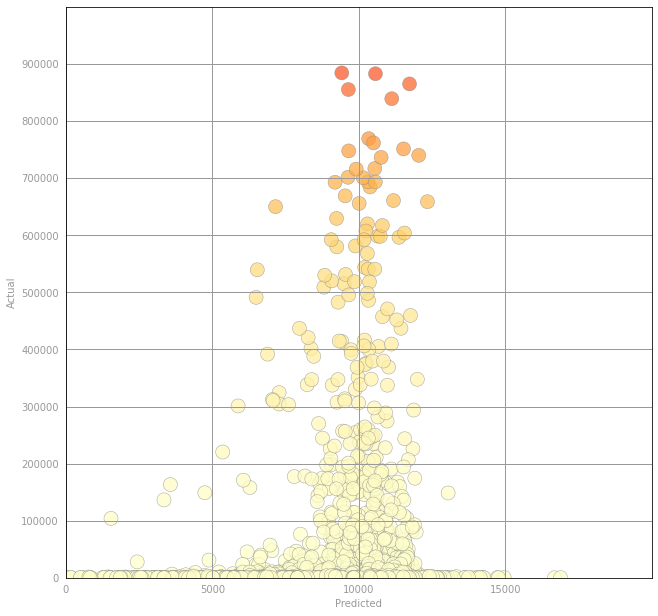

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap

cmap = get_cmap('YlOrRd')

#returns template for generating plot data
def preparePlot(xticks, yticks, figsize=(10.5, 10.5), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

predictions = np.asarray(finalResults.map(lambda x: x[1]).collect())

actual = np.asarray(finalResults.map(lambda x: x[0]).collect())

error = np.asarray(finalResults.map(lambda x: squaredError(x[0], x[1])).collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 20000, 5000), np.arange(0, 1000000, 100000))
ax.set_xlim(0, 20000), ax.set_ylim(0, 1000000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass


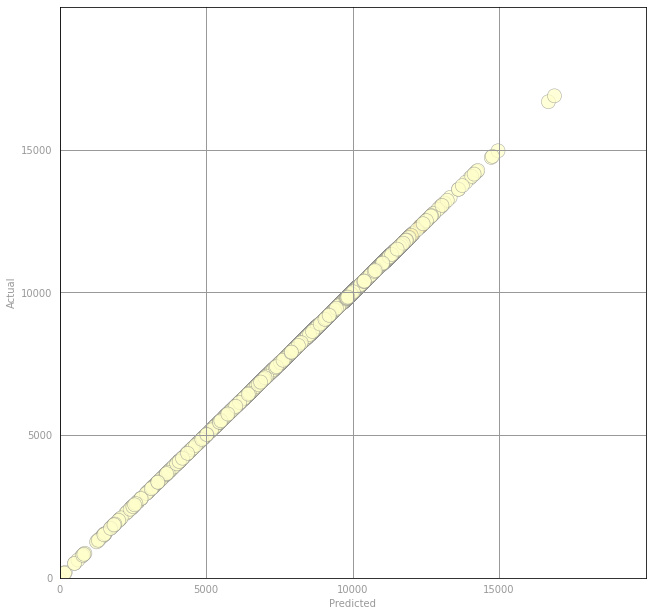

In [ ]:
fig, ax = preparePlot(np.arange(0, 20000, 5000), np.arange(0, 20000, 5000))
ax.set_xlim(0, 20000), ax.set_ylim(0, 20000)
plt.scatter(predictions, predictions, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass